# Compare CASTEP al3x3 benchmark performance

This notebook compares the performance of the small al3x3 benchmark across different UK HPC facilities.

Facilities included:

+ [ARCHER](http://www.archer.ac.uk): Cray XC30. 2x 18-core Xeon (IvyBridge) per node. Cray Aries dragonfly.
+ [Cirrus@EPCC](http://www.cirrus.ac.uk): HPE/SGI Ice XA, 2x 18-core Xeon (Broadwell) per node. FDR hypercube
+ Thomas@MMM: 2x 12-core Xeon (Broadwell) per node, ?DR 1:1 non-blocking (at the node counts investigated here)
+ Athena@HPCM+: 2x 14-core Xeon (Broadwell) per node, EDR 1:1 non-blocking (at the node counts investigated here)

In [1]:
import re
from matplotlib import pyplot as plt
%matplotlib inline

Define a function to get the mean SCF cycle time from CASTEP output files. Minimum and maximum times found are removed before mean is computed to remove skewing due to long first step or very short step.

In [2]:
def getmeancycle(castepfilename):
    infile = open(castepfilename, 'r')
    tvals = []
    for line in infile:
        if re.search('<-- SCF', line):
            line = line.strip()
            tokens = line.split()
            if re.match('[0-9]+', tokens[0].lstrip()):
                tvals.append(float(tokens[4]))
    infile.close()

    deltat = []
    for i in range(len(tvals)-1):
        deltat.append(tvals[i+1] - tvals[i])
        
    deltat.remove(max(deltat))
    deltat.remove(min(deltat))
    
    return sum(deltat)/len(deltat)

Cirrus results have versions compiled with both SGI MPT and Intel MPI

In [3]:
cirrusmptfiles = {1:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.1nodes',
                  2:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.2nodes',
                  4:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.4nodes'}

In [4]:
thomasfiles = {1:'../al3x3/results/Thomas/al3x3.castep.1nodes',
               2:'../al3x3/results/Thomas/al3x3.castep.2nodes'}

In [32]:
athenafiles = {1:'../al3x3/results/Athena/al3x3.castep.1nodes',
               2:'../al3x3/results/Athena/al3x3.castep.2nodes',
               4:'../al3x3/results/Athena/al3x3.castep.4nodes',
               8:'../al3x3/results/Athena/al3x3.castep.8nodes',
               16:'../al3x3/results/Athena/al3x3.castep.16nodes'}

## Cirrus (MPT 2.14)

In [35]:
cirrusmptcores = []
cirrusmptscf = []
cirrusmptspeedup = []
cirrusmptcpn = 36
print "{:>15s} {:>15s} {:>15s} {:>15s}".format('Nodes', 'Cores', 'Mean SCF (s)', 'Speedup')
print "{:>15s} {:>15s} {:>15s} {:>15s}".format('=====', '=====', '============', '=======')
for nodes, filename in sorted(cirrusmptfiles.items()):
    cirrusmptcores.append(nodes*cirrusmptcpn)
    scf = getmeancycle(filename)
    cirrusmptscf.append(scf)
    speedup = cirrusmptscf[0]/scf
    cirrusmptspeedup.append(speedup)
    print "{:>15d} {:>15d} {:>15.1f} {:>15.2f}".format(nodes, nodes*cirrusmptcpn, scf, speedup)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              36           102.4            1.00
              2              72            50.0            2.05
              4             144            31.4            3.27


## Thomas

In [36]:
thomascores = []
thomasscf = []
thomasspeedup = []
thomascpn = 24
print "{:>15s} {:>15s} {:>15s} {:>15s}".format('Nodes', 'Cores', 'Mean SCF (s)', 'Speedup')
print "{:>15s} {:>15s} {:>15s} {:>15s}".format('=====', '=====', '============', '=======')
for nodes, filename in sorted(thomasfiles.items()):
    thomascores.append(nodes*thomascpn)
    scf = getmeancycle(filename)
    thomasscf.append(scf)
    speedup = thomasscf[0]/scf
    thomasspeedup.append(speedup)
    print "{:>15d} {:>15d} {:>15.1f} {:>15.2f}".format(nodes, nodes*thomascpn, scf, speedup)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              24           123.3            1.00
              2              48            52.9            2.33


## Athena

In [37]:
athenacores = []
athenascf = []
athenaspeedup = []
athenacpn = 28
print "{:>15s} {:>15s} {:>15s} {:>15s}".format('Nodes', 'Cores', 'Mean SCF (s)', 'Speedup')
print "{:>15s} {:>15s} {:>15s} {:>15s}".format('=====', '=====', '============', '=======')
for nodes, filename in sorted(athenafiles.items()):
    athenacores.append(nodes*athenacpn)
    scf = getmeancycle(filename)
    athenascf.append(scf)
    speedup = athenascf[0]/scf
    athenaspeedup.append(speedup)
    print "{:>15d} {:>15d} {:>15.1f} {:>15.2f}".format(nodes, nodes*athenacpn, scf, speedup)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              28           100.6            1.00
              2              56            48.7            2.07
              4             112            40.1            2.51
              8             224            15.2            6.62
             16             448            18.8            5.35


## Performance Comparison

### Mean SCF cycle time

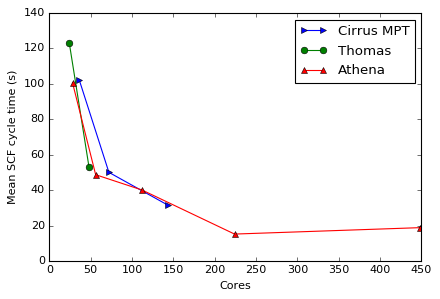

In [38]:
plt.plot(cirrusmptcores, cirrusmptscf, '>-', label='Cirrus MPT')
plt.plot(thomascores, thomasscf, 'o-', label='Thomas')
plt.plot(athenacores, athenascf, '^-', label='Athena')
plt.xlabel('Cores')
plt.ylabel('Mean SCF cycle time (s)')
plt.legend(loc='best')

### Speedup (relative to 1 node)

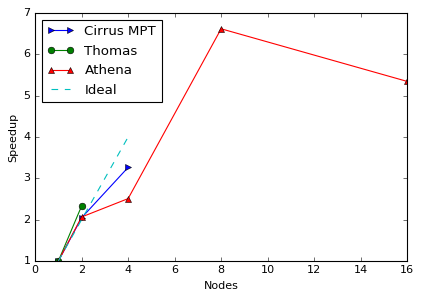

In [39]:
plt.plot([x/cirrusmptcpn for x in cirrusmptcores], cirrusmptspeedup, '>-', label='Cirrus MPT')
plt.plot([x/thomascpn for x in thomascores], thomasspeedup, 'o-', label='Thomas')
plt.plot([x/athenacpn for x in athenacores], athenaspeedup, '^-', label='Athena')
x = range(1,5)
plt.plot(x, x, '--', label='Ideal')
plt.xlabel('Nodes')
plt.ylabel('Speedup')
plt.legend(loc='best')